In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

2024-11-05 18:30:24.770739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

In [11]:
print("Contents of Base dir: ",base_dir)
print("Contents of train_dir: ",train_dir)
print("Contents of validation_dir: ",validation_dir)

Contents of Base dir:  cats_and_dogs_filtered
Contents of train_dir:  cats_and_dogs_filtered/train
Contents of validation_dir:  cats_and_dogs_filtered/validation


In [12]:
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

validation_cats_fnames = os.listdir(validation_cats_dir)
validation_dogs_fnames = os.listdir(validation_dogs_dir)

print("train_cats_fnames.length:",len(train_cats_fnames))
print("train_dogs_fnames.length:",len(train_dogs_fnames))

print("validation_cats_fnames.length:",len(validation_cats_fnames))
print("validation_dogs_fnames.length:",len(validation_dogs_fnames))

train_cats_fnames.length: 1000
train_dogs_fnames.length: 1000
validation_cats_fnames.length: 500
validation_dogs_fnames.length: 500


In [13]:
print("first 5 fnames in train_cats_dir:",train_cats_fnames[:5])
print("first 5 fnames in train_dogs_dir:",train_dogs_fnames[:5])
print()
print("first 5 fnames in validation_cats_dir:",validation_cats_fnames[:5])
print("first 5 fnames in validation_dogs_dir:",validation_dogs_fnames[:5])

first 5 fnames in train_cats_dir: ['cat.803.jpg', 'cat.464.jpg', 'cat.882.jpg', 'cat.779.jpg', 'cat.194.jpg']
first 5 fnames in train_dogs_dir: ['dog.917.jpg', 'dog.795.jpg', 'dog.734.jpg', 'dog.715.jpg', 'dog.105.jpg']

first 5 fnames in validation_cats_dir: ['cat.2270.jpg', 'cat.2321.jpg', 'cat.2216.jpg', 'cat.2414.jpg', 'cat.2498.jpg']
first 5 fnames in validation_dogs_dir: ['dog.2141.jpg', 'dog.2449.jpg', 'dog.2363.jpg', 'dog.2097.jpg', 'dog.2038.jpg']


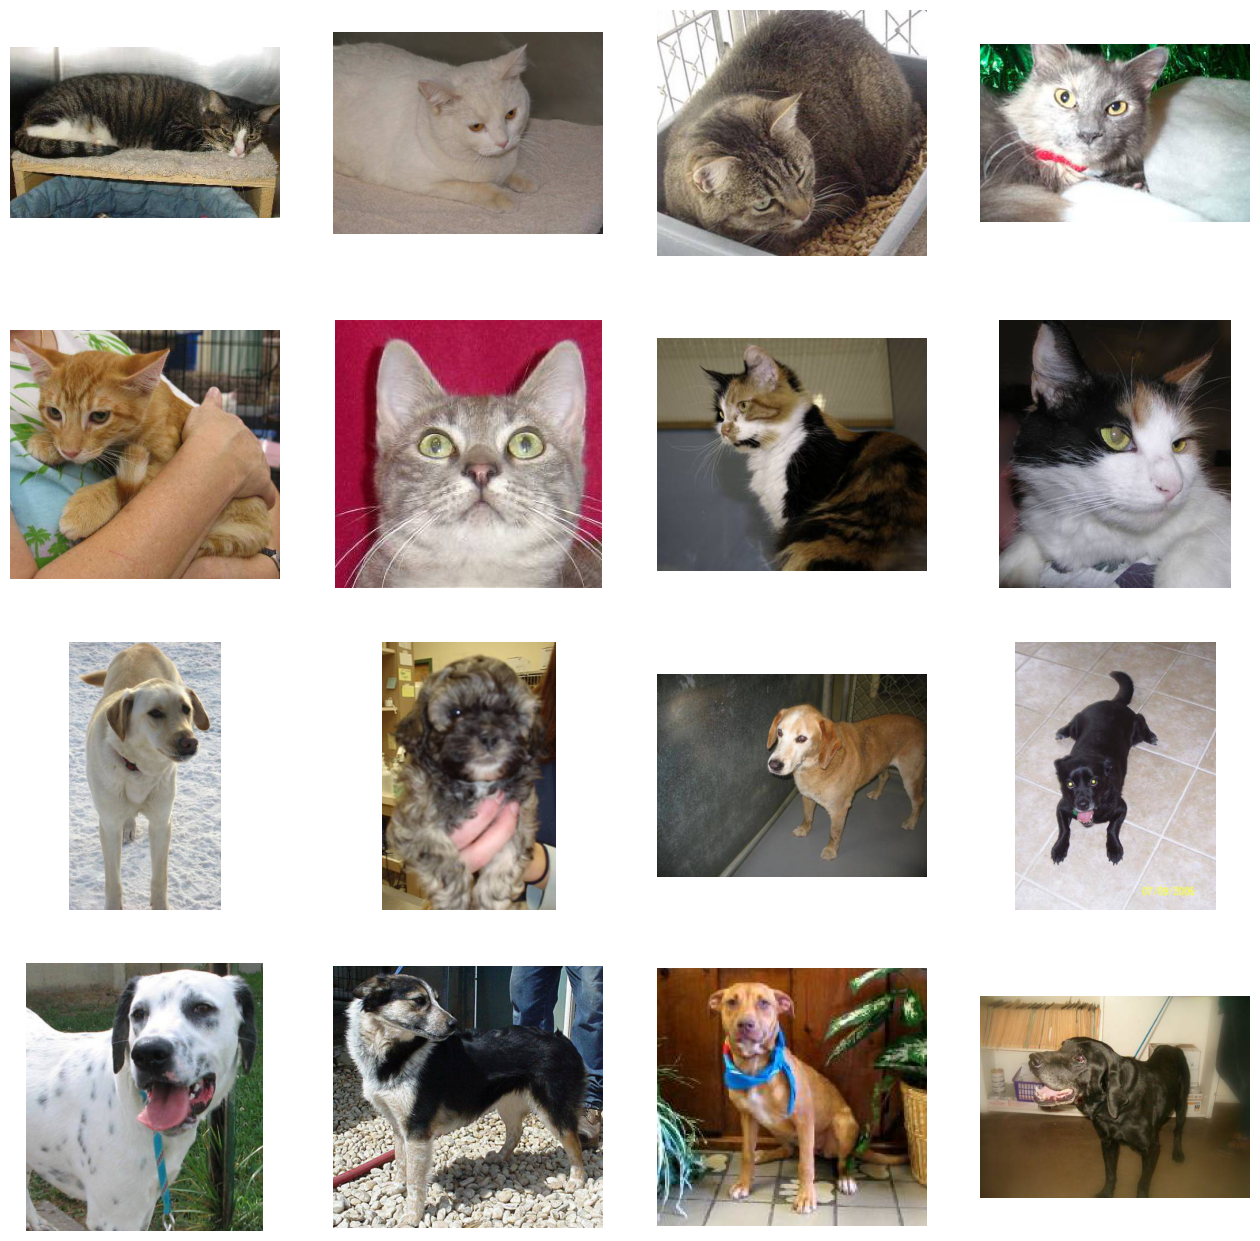

In [15]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cats_fnames, k=8)]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dogs_fnames, k=8)]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [18]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.Rescaling(.1/255),

    tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(514,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

2024-11-05 19:15:53.676876: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1

In [21]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [22]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (150,150),
    batch_size = 20,
    label_mode = 'binary'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size = (150,150),
    batch_size = 20,
    label_mode = 'binary'
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [23]:
shuffle_buffer_size = 1000
prefetch_buffer_size = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size = prefetch_buffer_size)
validation_dataset_final = validation_dataset.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size = prefetch_buffer_size)

In [27]:
history = model.fit(
    train_dataset_final,
    epochs = 15,
    validation_data = validation_dataset_final,
    verbose = 2
)

Epoch 1/15


2024-11-05 19:42:27.153770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2024-11-05 19:42:27.155492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2024-11-05 19:43:41.062012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000

100/100 - 82s - loss: 0.6946 - accuracy: 0.5235 - val_loss: 0.6924 - val_accuracy: 0.5000 - 82s/epoch - 819ms/step
Epoch 2/15
100/100 - 69s - loss: 0.6921 - accuracy: 0.5255 - val_loss: 0.6894 - val_accuracy: 0.5150 - 69s/epoch - 691ms/step
Epoch 3/15
100/100 - 67s - loss: 0.6907 - accuracy: 0.5350 - val_loss: 0.6793 - val_accuracy: 0.5960 - 67s/epoch - 674ms/step
Epoch 4/15
100/100 - 62s - loss: 0.6772 - accuracy: 0.5810 - val_loss: 0.6753 - val_accuracy: 0.5790 - 62s/epoch - 621ms/step
Epoch 5/15
100/100 - 62s - loss: 0.6536 - accuracy: 0.6110 - val_loss: 0.6522 - val_accuracy: 0.6140 - 62s/epoch - 617ms/step
Epoch 6/15
100/100 - 62s - loss: 0.6231 - accuracy: 0.6530 - val_loss: 0.6707 - val_accuracy: 0.6270 - 62s/epoch - 618ms/step
Epoch 7/15
100/100 - 66s - loss: 0.5978 - accuracy: 0.6760 - val_loss: 0.6092 - val_accuracy: 0.6600 - 66s/epoch - 659ms/step
Epoch 8/15
100/100 - 61s - loss: 0.5638 - accuracy: 0.7130 - val_loss: 0.6647 - val_accuracy: 0.6260 - 61s/epoch - 606ms/step
Epo

In [28]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

1/1 [==============================] - 0s 110ms/step


/tmp/ipykernel_5792/1211776280.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()


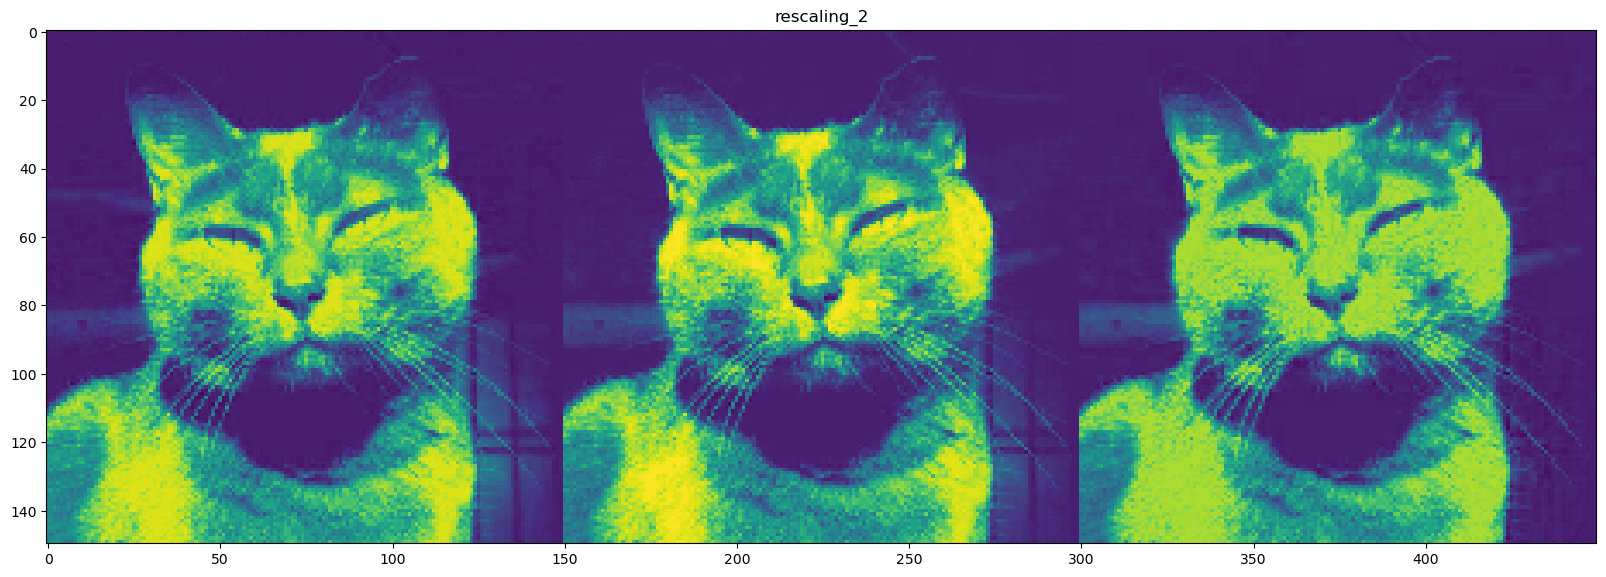

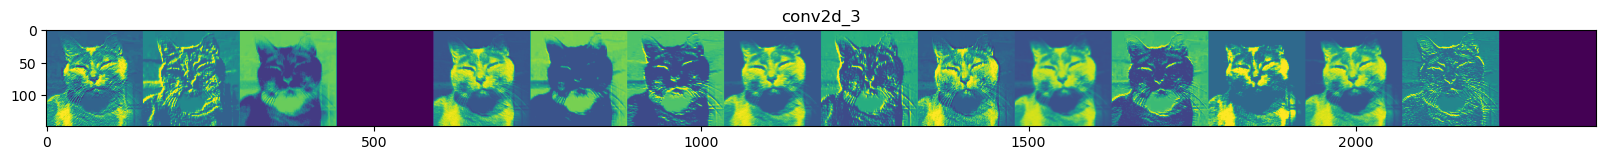

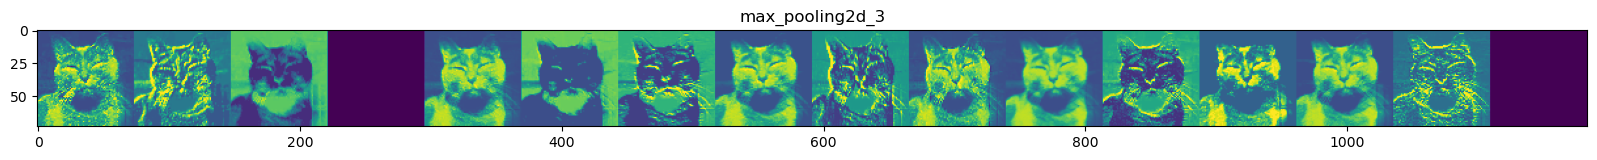

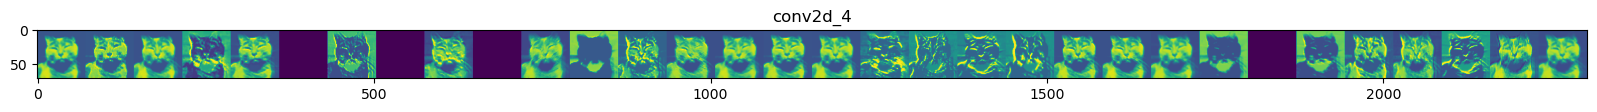

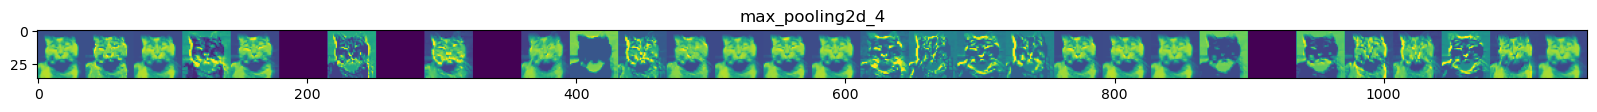

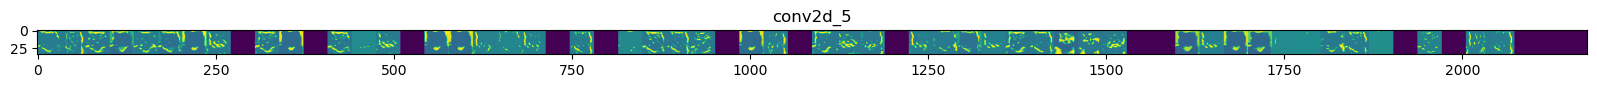

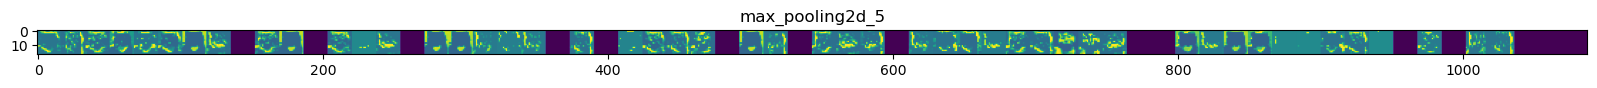

In [30]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = tf.keras.utils.img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

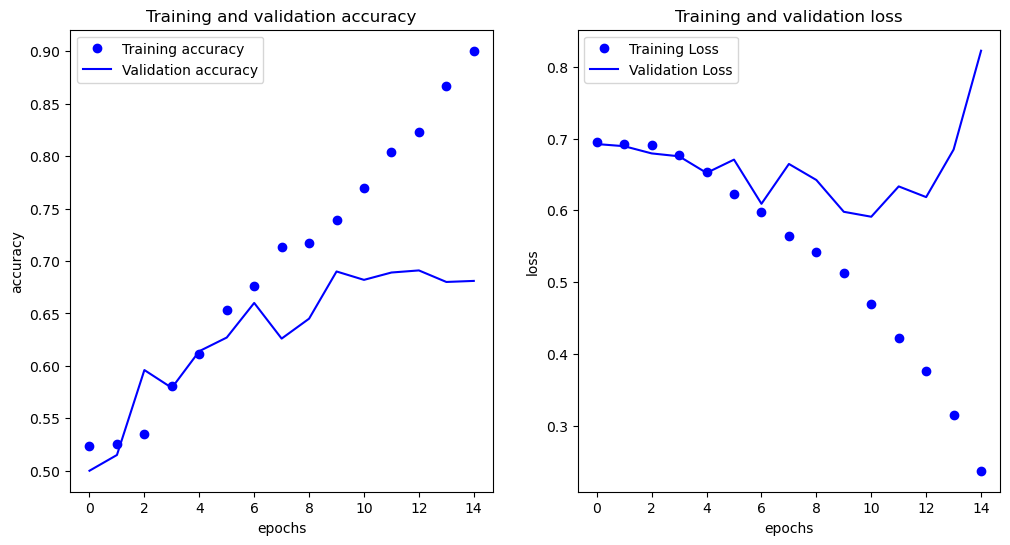

In [31]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)